In [1]:
import torch
import torch.nn as nn
import math


class TinySleepNet(nn.Module):
    def __init__(self, in_channel=1, input_size=200, num_classes=2):
        super(TinySleepNet, self).__init__()
        drate = 0.5 
        self.num_classes = num_classes
        self.in_channel = in_channel
        self.fs = math.floor(input_size/30)
        self.output_length = 512        
        
        self.feature_extract = nn.Sequential(
            nn.Conv1d(self.in_channel, 64, kernel_size=int(self.fs/2) , stride=int(self.fs/4), bias=False, padding=int(self.fs/4 - 1)),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=8, stride=8, padding=4, ceil_mode=True),
            nn.Dropout(drate),

            nn.Conv1d(64, 128, kernel_size=9, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.Conv1d(128, 128, kernel_size=9, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.Conv1d(128, 128, kernel_size=9, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.MaxPool1d(kernel_size=4, stride=4),
            nn.Dropout(drate)        
        )
        #self.lstm = nn.LSTM(input_size = 512, hidden_size = 128, num_layers = 2, bidirectional=False)
        self.lstm = nn.LSTM(input_size = self.output_length, hidden_size = 128, num_layers = 2, bidirectional=True)
        self.dropout = nn.Dropout(drate)
        self.bn = nn.BatchNorm1d(256)
        self.relu = nn.ReLU(inplace=True)        
        self.fc_out = nn.Linear(256,self.num_classes)
    
       # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad        

    def forward(self, x):
        ## Feature extraction
        x = self.feature_extract(x)
        ## LSTM
        x = x.view(x.shape[0],1,-1)
        self.lstm.flatten_parameters()
        x, _ = self.lstm(x)
        x = x.view(x.shape[0],-1)
        x = self.dropout(x)
        x = self.bn(x)
        x = self.relu(x)
        ## FC and softmax       
        #x = x.view(x.shape[0],-1) 
        out = self.fc_out(x)
        return out
        

if __name__=="__main__":
    #model = CNN_1D()
    esize = 4
    model = TinySleepNet(in_channel = 1, input_size=750)
    print("Parameters : ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    inputs = torch.rand((5,1,750))
    print(model(inputs))

Parameters :  1424002
tensor([[ 0.0578, -0.3144],
        [ 0.2636, -0.4993],
        [ 0.0228,  0.4191],
        [-0.1089, -0.1392],
        [ 0.3110, -0.1520]], grad_fn=<AddmmBackward0>)


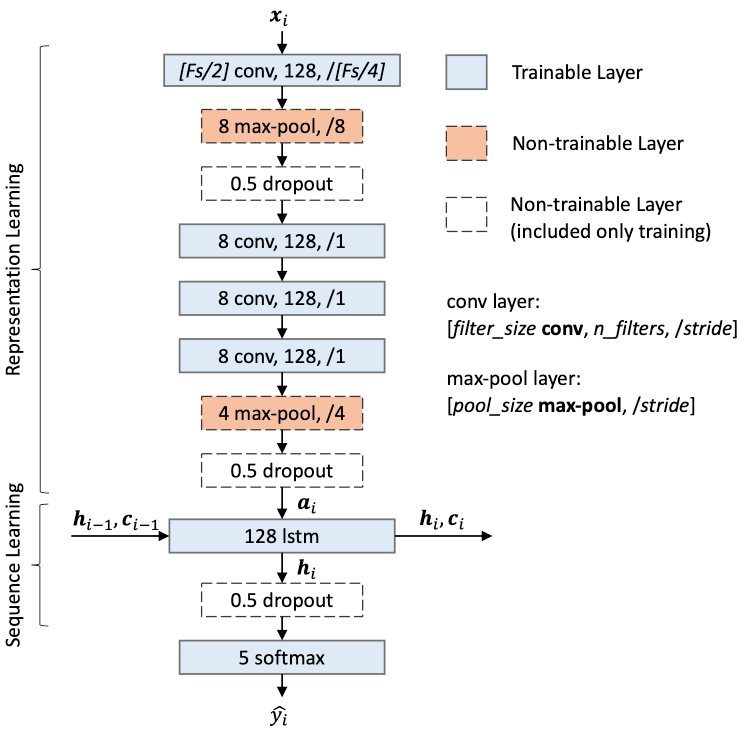